# Kostrov summation

## 43 boxes
## From moment sensors to deformation, strain rate and velocity

In [158]:
from shapely.geometry import Point, mapping
from shapely.geometry.polygon import Polygon
from shapely.geometry import shape
from shapely.ops import transform
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shapely as sp
import pyproj

with open('caribbean7decmw0.txt') as f:
    array = [[x for x in line.split()] for line in f]
cmt_data = np.array(array)

In [159]:
# specify the polygons
import geopandas as gpd
import matplotlib.pyplot as plt

# enabling reading kml files with geopandas
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

fp = "final_polygons.kml"
polys = gpd.read_file(fp, driver='KML')
polygons = polys[['geometry']]

import pandas as pd
import shapely as sp
def coord_lister(geom):
    coords = list(geom.exterior.coords)
    return (coords)

coordinates = polygons.geometry.apply(coord_lister)

## Seismic moment - magnitude relationship

In [160]:
import warnings
warnings.filterwarnings("ignore") # filter warnings for changing coordinate systems

def kostrov_summation(eq_zone):
    # kostrov summation
    mrr = 0
    mtt = 0
    mpp = 0
    mrt = 0
    mrp = 0
    mtp = 0
    scalar_moment = 0

    # sum up all tensors
    for i in range(len(eq_zone)):
        iexp = int(eq_zone[i][9])
        mrr += float(eq_zone[i][3])*10**iexp
        mtt += float(eq_zone[i][4])*10**iexp
        mpp += float(eq_zone[i][5])*10**iexp
        mrt += float(eq_zone[i][6])*10**iexp
        mrp += float(eq_zone[i][7])*10**iexp
        mtp += float(eq_zone[i][8])*10**iexp
        
        scalar_moment += float(eq_zone[i][14])
        
    # convert from dyn cm to Nm   
    mrr = mrr/10**7
    mtt = mtt/10**7
    mpp = mpp/10**7
    mrt = mrt/10**7
    mrp = mrp/10**7
    mtp = mtp/10**7
    
     # convert to float notation 
    mrr = mrr/10**16
    mtt = mtt/10**16
    mpp = mpp/10**16
    mrt = mrt/10**16
    mrp = mrp/10**16
    mtp = mtp/10**16
    
    return mrr, mtt, mpp, mrt, mrp, mtp


# store tensors
tensors = []
coords = []
frequency = []
scalar_moments = []
box_depth = []
max_box_depth = []
mean_box_depth = []
areas = []

# depth constraints on boxes, mexico
box_depth1 = (-91.80953949802839, 12.906861060724344)
box_depth2 = (-89.35831739963655, 13.181528333815479)
box_depth3 = (-88.64458334948695, 13.991108344948625)
box_depth4 = (-83.30358287371013, 10.030047742119372)
box_depth5 = (-84.02616806517491, 8.858824465953603)
box_depth6 = (-88.33710672941535, 11.095631889667644)

# atlantic side
box_depth7 = (-60.0604751774371, 10.802684775900197)
box_depth8 = (-60.34008699007553, 17.9366145567412)
box_depth9 = (-66.94969911212416, 18.23183262090195)
box_depth10 = (-62.16092637903298, 16.327057534641476)
box_depth11 = (-69.7467461020565, 18.372244156357215)
box_depth12 = (-67.21882256716424, 19.305653288760155)
box_depth13 = (-64.62710336309205, 19.048392689545647)
box_depth14 = (-62.18852426874509, 18.056895146571513)
box_depth15 = (-60.34008699007553, 17.93661455674125)
box_depth16 = (-62.85911931879894, 10.523324857999352) # 60 km diep cutoff
box_depth17 = (-59.607810857910515, 14.652518442915289)

              
for i in coordinates:
    poly = Polygon(i)
    coord_poly = list(poly.centroid.coords)
    
    # keep track of number of earthquakes within polygon
    eq_zone = []
    eq_zone_depth = []
    freq_eqs1 = []
    freq_eqs2 = []
    scalar_moment1 = 0
    scalar_moment2 = 0
    number_eqs1 = 0
    eq_depths1 = 0
    max_depth1 = []
    number_eqs2 = 0
    eq_depths2 = 0
    max_depth2 = []
    depth_flag_atl = False
    depth_flag_mex = False
    for line in range(len(cmt_data)):
        x = (float(cmt_data[line][0]))
        y = (float(cmt_data[line][1]))
        point = Point(x,y)
        
        # add earthquakes to catalogue if it is within the polygon
        if (poly.contains(point)) == True:
            depth = (float(cmt_data[line][2]))
            # if we're in the right polygon, we will distinguish eqs between depths
            # depth constraints on boxes to do the summation twice. 
            
            # mexico side
            if coord_poly[0] == box_depth1 or coord_poly[0] == box_depth2 or coord_poly[0] == box_depth3 or coord_poly[0] == box_depth4 or coord_poly[0] == box_depth5 or coord_poly[0] == box_depth6:
                if depth < 60:
                    eq_zone.append(cmt_data[line])
                    eq_depths1 += depth
                    max_depth1.append(depth)
                    number_eqs1 += 1
                    scalar_moment1 += float(cmt_data[line][14])
                    freq_eqs1.append(float(cmt_data[line][13]))
                    depth_flag_mex = True
                else: 
                    eq_zone_depth.append(cmt_data[line])
                    eq_depths2 += depth
                    max_depth2.append(depth)
                    number_eqs2 += 1 
                    scalar_moment2 += float(cmt_data[line][14])
                    freq_eqs2.append(float(cmt_data[line][13]))
            # Atlanctic side        
            elif coord_poly[0] == box_depth7 or coord_poly[0] == box_depth8 or coord_poly[0] == box_depth9 or coord_poly[0] == box_depth10 or coord_poly[0] == box_depth11 or coord_poly[0] == box_depth12 or coord_poly[0] == box_depth13 or coord_poly[0] == box_depth14 or coord_poly[0] == box_depth15 or coord_poly[0] == box_depth16 or coord_poly[0] == box_depth17:
                if depth < 40:
                    eq_zone.append(cmt_data[line])
                    eq_depths1 += depth
                    max_depth1.append(depth)
                    number_eqs1 += 1
                    scalar_moment1 += float(cmt_data[line][14])
                    freq_eqs1.append(float(cmt_data[line][13]))
                    depth_flag_atl = True
                else: 
                    eq_zone_depth.append(cmt_data[line])
                    eq_depths2 += depth
                    max_depth2.append(depth)
                    number_eqs2 += 1 
                    scalar_moment2 += float(cmt_data[line][14])
                    freq_eqs2.append(float(cmt_data[line][13]))
            # if the box is not divided by depth, all earthquakes are included         
            else: 
                eq_zone.append(cmt_data[line])
                eq_depths1 += depth
                max_depth1.append(depth)
                number_eqs1 += 1
                scalar_moment1 += float(cmt_data[line][14])
                freq_eqs1.append(float(cmt_data[line][13]))
            # collect data for frequency magnitude plot
            
            
    if number_eqs1 == 0:
        mean_depth1 = 0
    else: 
        mean_depth1 = eq_depths1 / number_eqs1
        # seismogenic depth is depth where 90% of earthquakes lie in.
        max_depth1.sort()
        length = len(max_depth1)
        index = round(length*0.9)
        # index -1 to accomodate for counting from 0 in Python
        max_depths1 = max_depth1[index-1]
        max_box_depth.append(max_depths1 * 1000) #from kilometres to m
        mean_box_depth.append(mean_depth1)
        
    box_depth.append(max_depths1*1000) #from kilometres to m
    scalar_moments.append(scalar_moment1/10**7)# convert to Nm from dyn
    frequency.append([*coord_depth,*freq_eqs1])
    mrr,mtt,mpp,mrt,mrp,mtp = kostrov_summation(eq_zone)

    tensors.append([*coord_poly[0],mean_depth1,mrr,mtt,mpp,
                    mrt,mrp,mtp,16,'X', 'Y', '200808180916A'])
    
    # Calculate the areas of the polygon  
    s = shape(poly)
    # from spherical to cartesian coordinates
    proj = partial(pyproj.transform, pyproj.Proj(init='epsg:4326'),
               pyproj.Proj(init='epsg:3857'))
    s_new = transform(proj, s)
    poly_area = transform(proj, s).area
    areas.append(poly_area)
    
    # if eq_zone_depth is not empty, we will do kostrov summation on a bottom of box as well
    if len(eq_zone_depth) != 0:
        mean_depth2 = eq_depths2 / number_eqs2
        mean_box_depth.append(mean_depth2)
        if depth_flag_atl == True:
            # 40 km is the upper depth of the box
            # seismogenic depth is depth where 90% of earthquakes lie in.
            max_depth2.sort()
            length2 = len(max_depth2)
            index2 = round(length2*0.9)
            # index -1 to accomodate for counting from 0 in Python
            # -40 to get the right height of the box
            max_depths2 = float(max_depth2[index2 - 1]) - 40
            max_box_depth.append(max_depths2 * 1000) #from kilometres to m
        elif depth_flag_mex == True:
            # 60 km is the upper depth of the box
            # seismogenic depth is depth where 90% of earthquakes lie in.
            max_depth2.sort()
            length2 = len(max_depth2)
            index2 = round(length2*0.9)
            # index -1 to accomodate for counting from 0 in Python
            # -60 to get the right height of the box
            max_depths2 = float(max_depth2[index2 - 1]) - 60
            max_box_depth.append(max_depths2 * 1000) #from kilometres to m
        
        # two boxes for depths so area twice in the list
        areas.append(poly_area)
        box_depth.append(mean_depth2*1000) #from kilometres t
        scalar_moments.append(scalar_moment2/10**7)# convert to Nm from dyn
        dmrr, dmtt, dmpp, dmrt, dmrp, dmtp = kostrov_summation(eq_zone_depth)    
        frequency.append([*coord_depth,*freq_eqs2])
        # want new coordinates for deep boxes in order to recognise them on the GMT map
        coord_depth = np.subtract(coord_poly[0], (0.5, 1))
        tensors.append([*coord_depth,mean_depth2,dmrr,dmtt,dmpp,
                    dmrt,dmrp,dmtp,16,'X', 'Y', '200808180916D'])

    

In [161]:
# run if error message on coord_depth comes up and then run box above again
coord_depth = np.subtract(coord_poly[0], (0.5, 0.5))

In [162]:
tensor = np.array(tensors)
#tensor = tensor.astype(np.float)
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

np.savetxt('polygons43.txt', tensor, delimiter = ' ', fmt="%s")

## MTTK

## Seismic consistency

In [163]:
# go to MTTK and calculate moment tensor for summed txt
def seismic_consistency (M0, sumM0):
    return M0/sumM0

with open('m0_polygons43.txt') as f:
    array = [[x for x in line.split()] for line in f]
m0_data = np.array(array)

cs = []
# from MTTK make list of M0 from given moment tensors
for i in range(len(m0_data)):
    M0 = (float(m0_data[i][13]))
    sumM0 = scalar_moments[i] 
    c_s = seismic_consistency (M0, sumM0)
    cs.append(c_s)
    if c_s < 0.8:
        #print(tensor[i][0], tensor[i][1])
        print(cs[i])


0.7460300543536181
0.568278683866568
0.7360834227879158
0.772336793040839
0.6329113924050633
0.7221780891167763
0.4606077272102296
0.5723394693777187
0.6049149338374291
0.7585112012700652
0.6781068364240244


## Frequency-magnitude plots

1
3
5
20
23
25
28
30
31
38


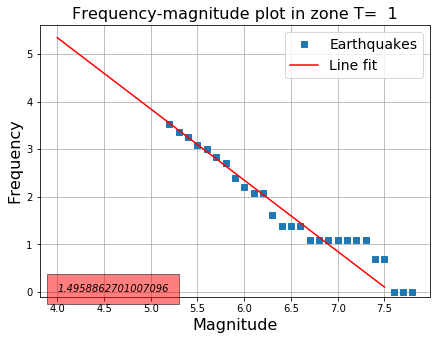

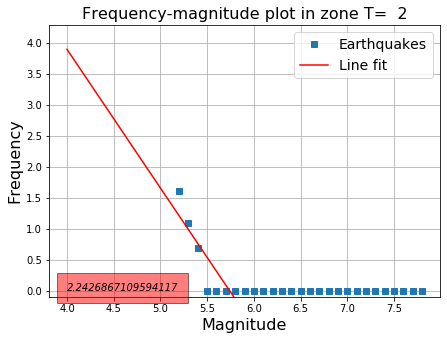

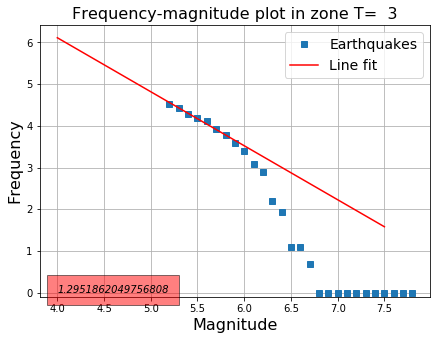

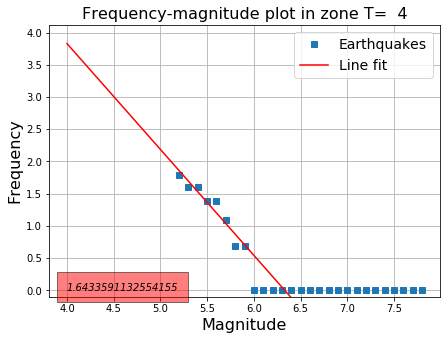

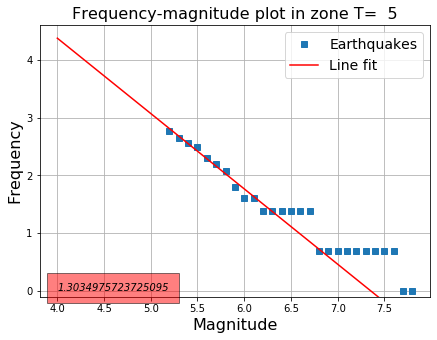

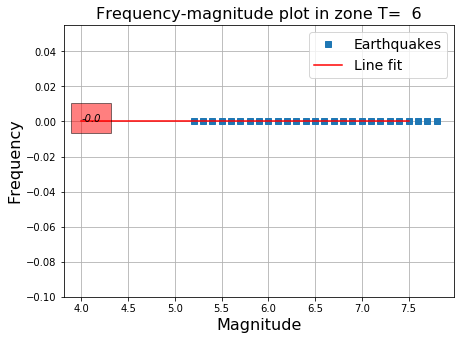

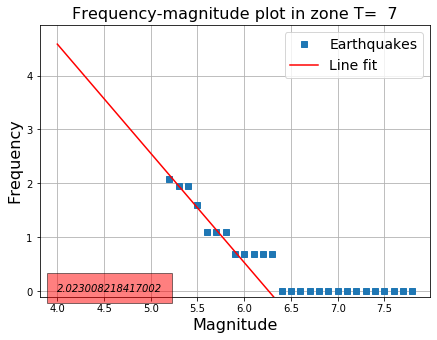

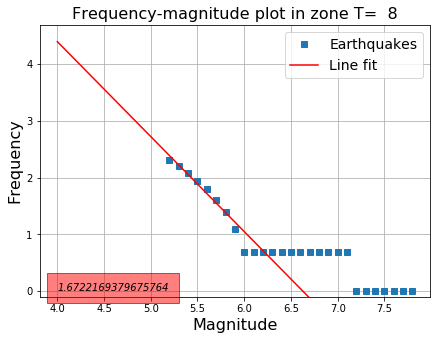

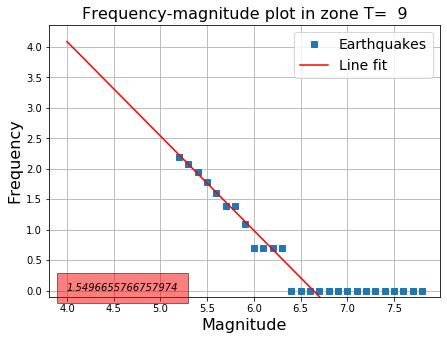

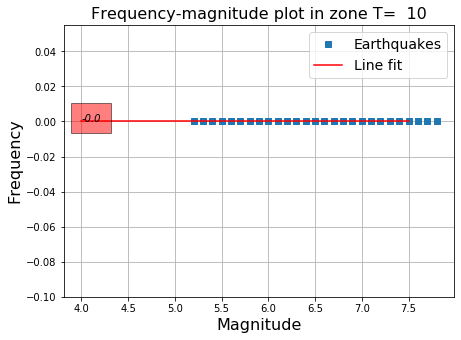

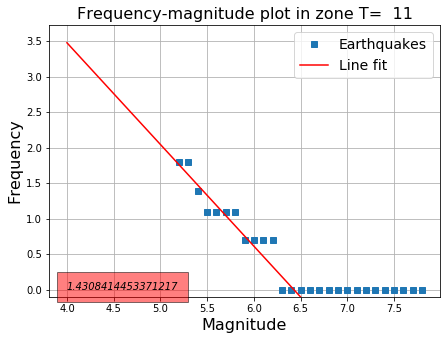

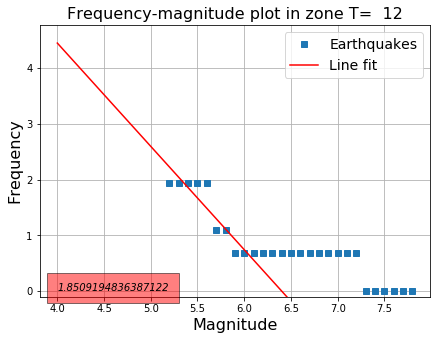

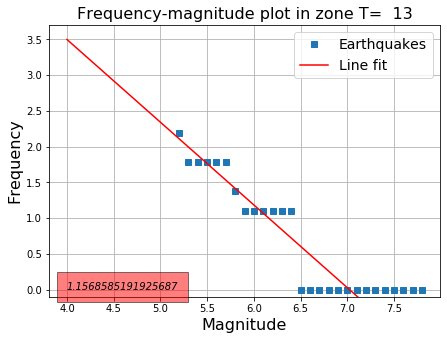

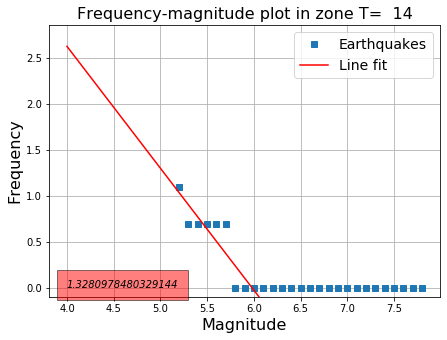

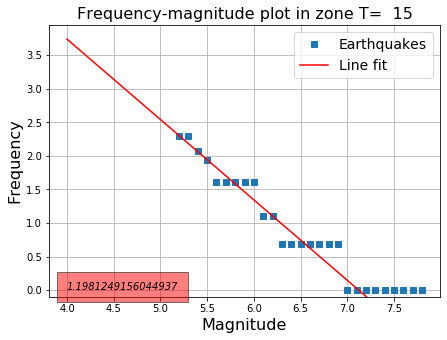

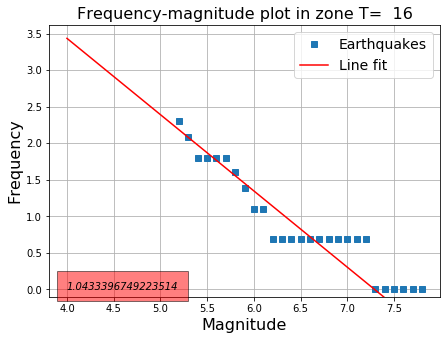

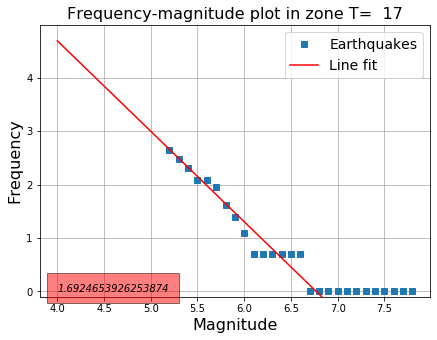

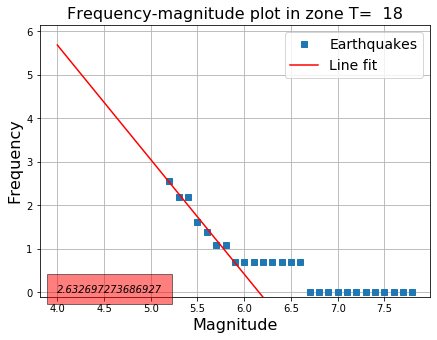

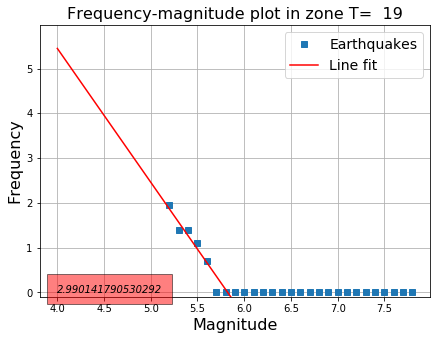

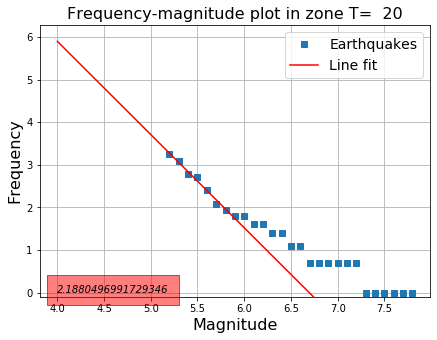

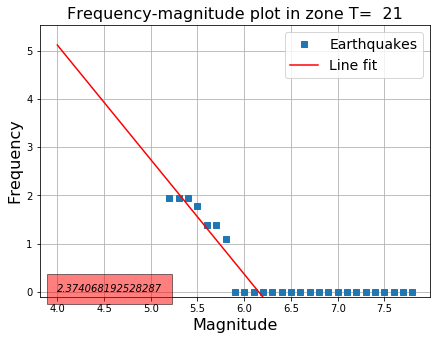

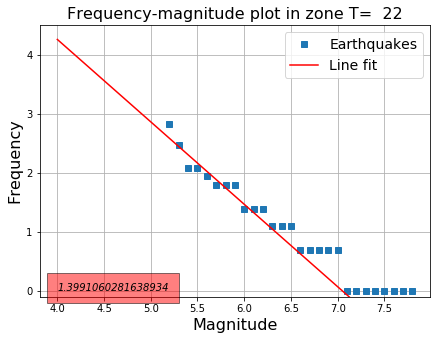

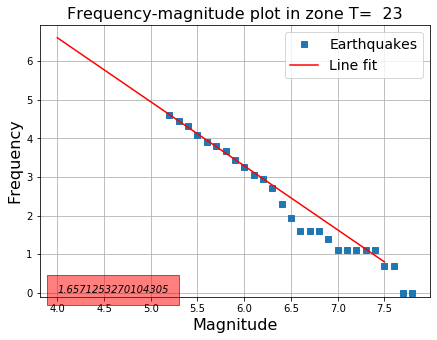

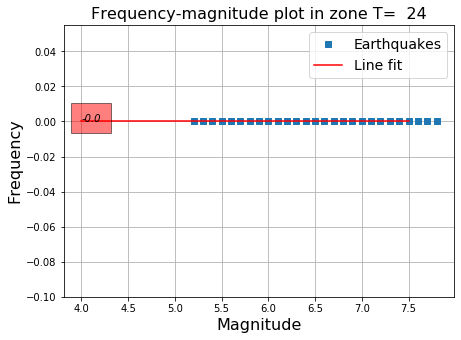

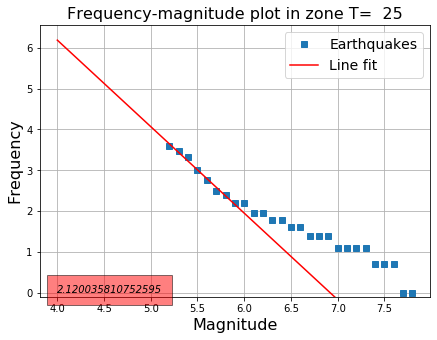

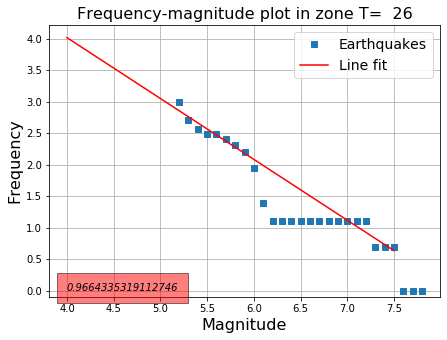

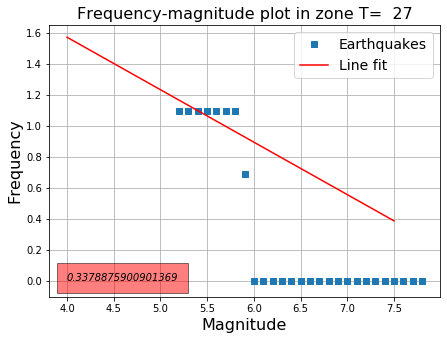

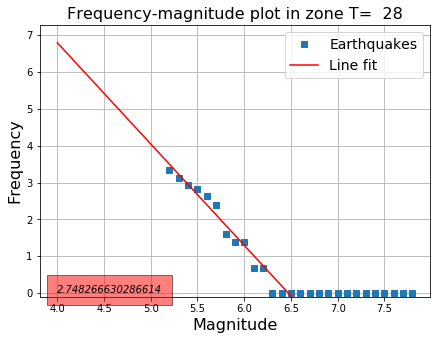

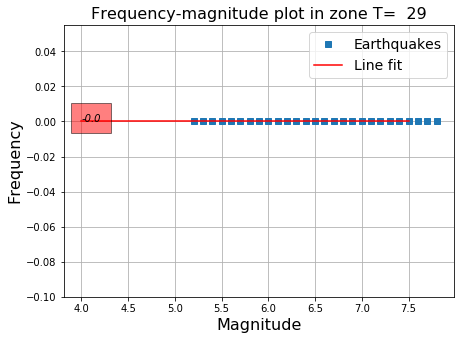

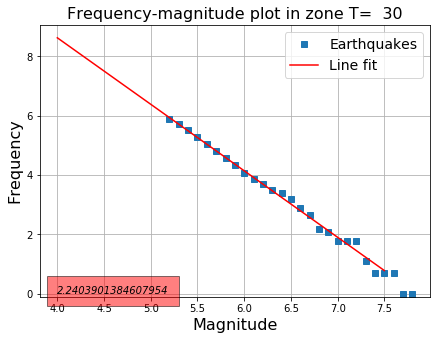

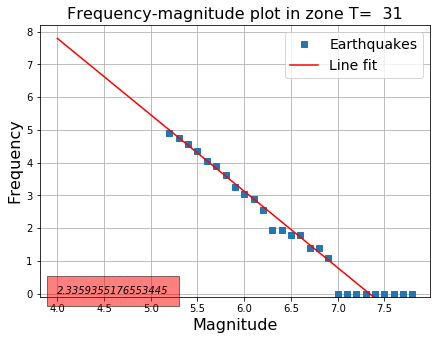

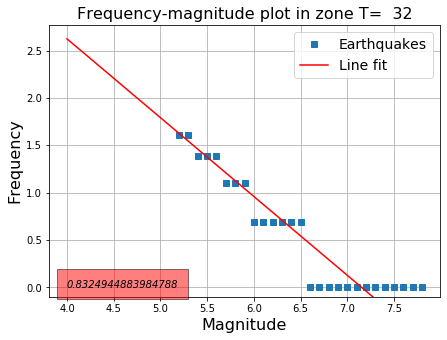

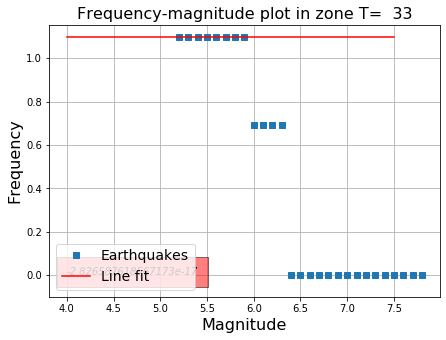

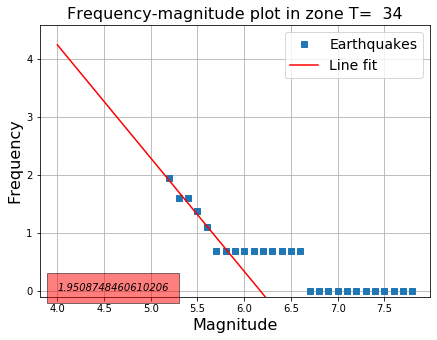

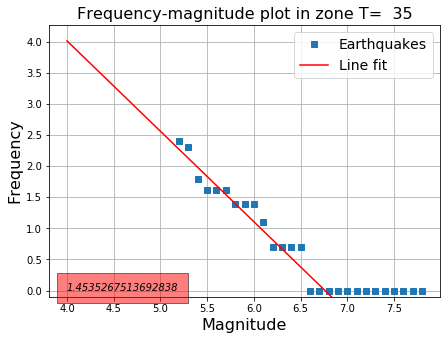

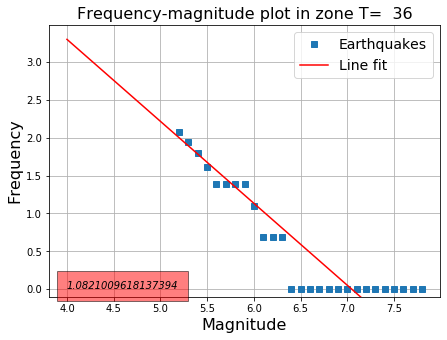

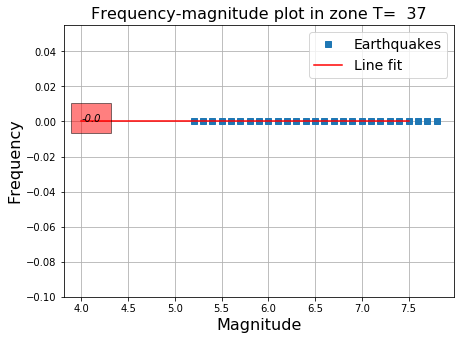

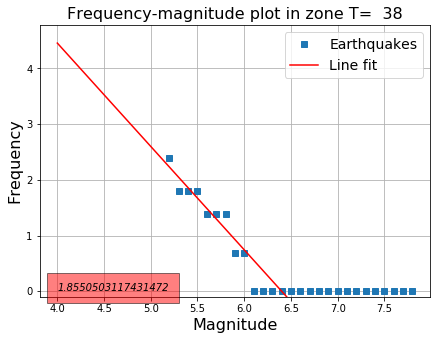

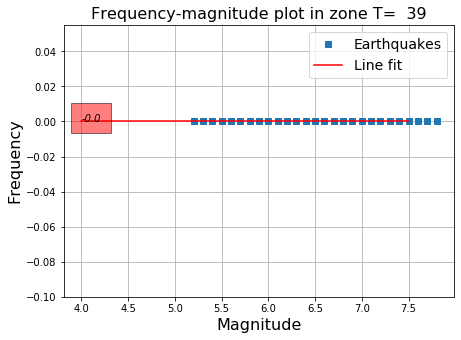

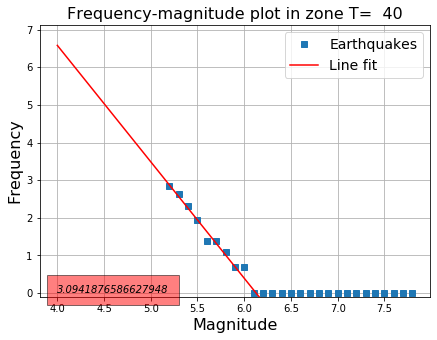

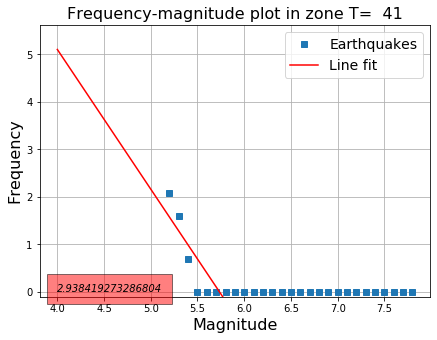

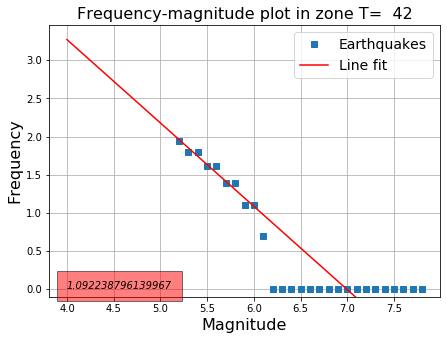

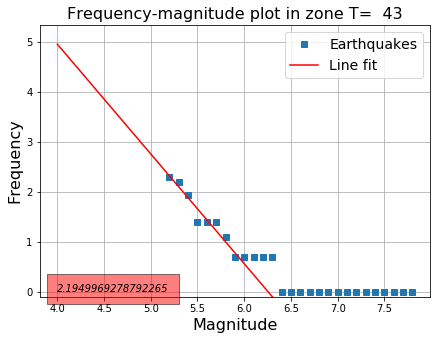

In [164]:
b_values = []
bs = []
b_plot =[]
freq = frequency
box_count = 0
for line in freq:
    box_count += 1
    i = 4.5
    x = [0.5,1,1.5,2,2.5,3,3.5,4]
    while i < 8:
        x.append(round(i,2))
        i += 0.1
    x.append(8.5)
    x.append(9)
    x.append(9.5)
    y = [0] * len(x)
    coord_lon = line.pop(0)
    coord_lat = line.pop(1)
    for i in line:
        if (i > 0.5):
            # all eqs above 0.5
            y [0] += 1
        if i > 1:
            # between 0.5 and 1
            y [1] += 1
        if i > 1.5:
            y [2] += 1
        if i > 2:
            y [3] += 1
        if i > 2.5:
            y [4] += 1
        if i > 3:
            y [5] += 1
        if i > 3.5:
            y [6] += 1
        if i > 4:
            y [7] += 1
        if i > 4.5:
            y [8] += 1
        if i > 4.6:
            y [9] += 1
        if i > 4.7:
            y [10] += 1
        if i > 4.8:
            y [11] += 1
        if i > 4.9:
            y [12] += 1
        if i > 5:
            y [13] += 1
        if i > 5.1:
            y [14] += 1
        if i > 5.2:
            y [15] += 1
        if i > 5.3:
            y [16] += 1
        if i > 5.4:
            y [17] += 1
        if i > 5.5:
            y [18] += 1
        if i > 5.6:
            y [19] += 1
        if i > 5.7:
            y [20] += 1
        if i > 5.8:
            y [21] += 1
        if i > 5.9:
            y [22] += 1
        if i > 6:
            y [23] += 1
        if i > 6.1:
            y [24] += 1
        if i > 6.2:
            y [25] += 1
        if i > 6.3:
            y [26] += 1
        if i > 6.4:
            y [27] += 1
        if i > 6.5:
            y [28] += 1
        if i > 6.6:
            y [29] += 1
        if i > 6.7:
            y [30] += 1
        if i > 6.8:
            y [31] += 1
        if i > 6.9:
            y [32] += 1
        if i > 7:
            y [33] += 1
        if i > 7.1:
            y [34] += 1
        if i > 7.2:
            y [35] += 1
        if i > 7.3:
            y [36] += 1
        if i > 7.4:
            y [37] += 1
        if i > 7.5:
            y [38] += 1
        if i > 7.6:
            y [39] += 1
        if i > 7.7:
            y [40] += 1
        if i > 7.8:
            y [41] += 1
        if i > 7.9:
            y [42] += 1
        if i > 8:
            y [43] += 1 
        if i > 8.5:
            y [44] += 1
        if i > 9:
            y [45] += 1
        if i > 9.5:
            y [46] += 1 

    """
    # Boolean mask
    mask = y != 0
    y = y[mask]
    x = x[mask"
"""
    logy = [np.log(z) for z in y if z != 0]
    #logy = np.log10(y)
    # straight-line fit with numpy polyfit
    poly_coeffs = np.polyfit(x[15:23], logy[15:23], 1)
    x_line = np.linspace(4, 7.5, 100)
    p1 = np.poly1d(poly_coeffs)
    b = poly_coeffs[0] * -1
    # only for top polygons plot the b-value
    b_plot.append(b)
    b_values.append([coord_lon, coord_lat, b])
    if y[1] > 30:
        if abs(b) == 0:
            bs.append(0.1)
        else:
            bs.append(b)
            print(box_count)
            # loglog plot
    else: bs.append(np.nan)
    
    
    fig = plt.figure(figsize=(7,5))
    ax1 = plt.subplot(111)
    ax1.plot(x[15:42], logy[15:42], 's', label='Earthquakes')
    ax1.plot(x_line, p1(x_line), 'r', label = 'Line fit')
    # T number relates to box number in the box43 excel sheet
    ax1.set_title('Frequency-magnitude plot in zone T=  {}'.format(box_count), fontsize=16)
    #ax1.set_title('Frequency-magnitude plot of the Honduras Depression', fontsize=16)
    ax1.grid(True)
    ax1.set_ylim(-0.1)
    ax1.text(4, 0, b, style='italic',
    bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
    ax1.set_xlabel('Magnitude', fontsize=16)
    ax1.set_ylabel('Frequency', fontsize=16)
    ax1.legend(loc='best', fontsize=14)
    

------------------------------------------------------------------------------------

# USE MTTK IN LINUX!

In [165]:
df = pd.read_excel (r'box_info35.xlsx', columns= ['coordinates', 'eigenvalues'])
values = df.to_numpy()
print((values))

[[-85.0905260077747 17.2271516472254 'Swan Island Transform' ... nan nan
  nan]
 [-86.759227093664 15.6912186410963 'Honduras Depression' ... nan nan nan]
 [-82.5556145178965 6.16605363315168 'Panama fracture zone' ... nan nan
  nan]
 ...
 [-63.188524268745 17.0568951465715 nan ... nan nan nan]
 [-60.3400869900755 17.9366145567412 'Lesser Antilles Trench' ... nan nan
  nan]
 [-69.5089153760404 10.7665058036997 'Oca fault' ... nan nan nan]]


In [166]:
f_clvds = []
f_clvds1= []
f_clvds2= []
f_clvds3= []
f_clvds4= []
f_clvds5= []

cs1 = []
cs2 = []
cs3 = []
cs4 = []
cs5 = []

# keep track of deformation types
def_types = []
for i in range(len(values)):
    # use eigenvalues as principal moments (Frölich and Anderson)
    # m_t is largest, m_b is intermediate, m_p is smallest eigenvalue
    m_t = float(values[i][4])
    m_b = float(values[i][5])
    m_p = float(values[i][6])
    # pure double couple: f = 0. For pure compensated linear vector dipole f= 0.5 (bad)
    f_clvd = (abs(m_b) / max(abs(m_t), abs(m_p)))
    f_clvds.append(f_clvd)
    
    def_type = float(values[i][24])
    if np.isnan(def_type) != True:
        def_types.append(def_type)
    if def_type == 1:
        f_clvds1.append(f_clvd)
        cs1.append(cs[i])
    elif def_type == 2:
        f_clvds2.append(f_clvd)
        cs2.append(cs[i])
    elif def_type == 3:
        f_clvds3.append(f_clvd)
        cs3.append(cs[i])
    elif def_type == 4:
        f_clvds4.append(f_clvd)
        cs4.append(cs[i])
    elif def_type == 5:
        f_clvds5.append(f_clvd)
        cs5.append(cs[i])

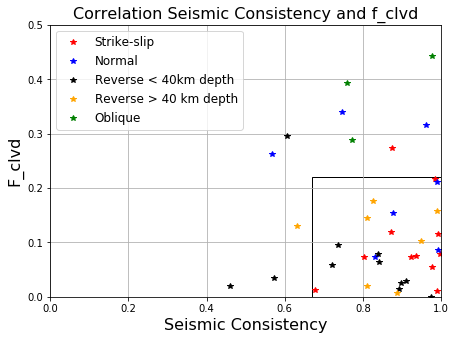

In [167]:
from matplotlib.patches import Rectangle
# plot f_clvd vs cs
poly_coeffs2 = np.polyfit(f_clvds,cs, 2)
x2_line = np.linspace(0, 1, 100)
p2 = np.poly1d(poly_coeffs2)

fig = plt.figure(figsize=(7,5))

plt.plot(cs1, (f_clvds1), '*', c = 'red', label = 'Strike-slip')
plt.plot(cs2, (f_clvds2), '*', c = 'blue', label = 'Normal')
plt.plot(cs3, (f_clvds3), '*', c = 'black', label = 'Reverse < 40km depth')
plt.plot(cs5, (f_clvds5), '*', c = 'orange', label = 'Reverse > 40 km depth')
plt.plot(cs4, (f_clvds4), '*', c = 'green' , label = 'Oblique')

plt.xlim([0,1])
plt.ylim([0,0.5])
plt.xlabel('Seismic Consistency', fontsize=16)
plt.ylabel('F_clvd', fontsize=16)
plt.title('Correlation Seismic Consistency and f_clvd', fontsize = 16)
plt.gca().add_patch(Rectangle((0.67,0),0.4,0.22,
                    edgecolor='black',
                    facecolor='none',
                    lw=1))
plt.legend(loc = 'best', prop={'size': 12})
plt.grid(True)

## Calculate strain and velocity
you are assigning a single velocity/strain rate solution to each box

In [169]:
# calculate strain tensor ON DIAGONALISED MATRIX!!!!! NOT THIS ONE
# strain = 1/(2*mu*V) * sum of moment tensors
# mu is 3.3*10ˆ10 according to (Stacey)
# divide by t too, time in seconds from start, to get de/dt

volumes = []
# calculate volume of all the boxes
for i in range(len(areas)):
    seismogenic_depth = max_box_depth[i] # corrections for seismogenic depth by literature review is done as well
    if seismogenic_depth == 0:
        seismogenic_depth = 0.1
    volume_box = float(areas[i]) * float(seismogenic_depth) # max depth or seismogenic depth
    volumes.append(volume_box)

mu = 3.3*10**10
strain_tensors = []

i = 0

for i in range(len(values)):
    e_t = float(values[i][4]*10**16)/float(mu*volumes[i]*2)
    e_b = float(values[i][5]*10**16)/float(mu*volumes[i]*2)
    e_p = float(values[i][6]*10**16)/float(mu*volumes[i]*2)
    lon = float(values[i][0])
    lat = float(values[i][1])
    strain_tensors.append([lon, lat, e_t, e_b, e_p])
    i += 1    

# compute strain rate
strain_rates = []
t = (2021-1976 + 10/12) 
for line in strain_tensors:
    et_t = float(line[2])/t
    et_b = float(line[3])/t
    et_p = float(line[4])/t
    strain_rates.append([float(line[0]), float(line[1]), et_t, et_b, et_p])

# string crosses from diagonalised summed moment tensors MTTK, gmt velo]

## compute strain crosses by making file
After using a bit of trigonometry to determine the horizontal components of the tensor

In [170]:
## make file to plot strain crosses
strain_crossesred = []
strain_crossesblue = []
strain_crosses = []
strain_b = []

for i in range(len(strain_rates)):
    lon_strain = strain_rates[i][0]
    lat_strain = strain_rates[i][1]
    I_strain = float(strain_rates[i][3])
    I_dip = np.deg2rad(float(values[i][9]))
    I_hor_strain = I_strain * np.cos(float(I_dip))
    T_strain = float(strain_rates[i][2])
    T_dip = np.deg2rad(float(values[i][11]))
    T_hor_strain = T_strain * np.cos(float(T_dip))
    P_strain = float(strain_rates[i][4])
    # horizontal strain = strain * P dip
    P_dip = np.deg2rad(float(values[i][7]))
    P_hor_strain = P_strain * np.cos(float(P_dip))
    P_strike = float(values[i][13])
    strain_crosses.append([lon_strain,lat_strain,T_hor_strain,P_hor_strain,P_strike])
    strain_crossesred.append([lon_strain,lat_strain,T_hor_strain,0,P_strike])
    strain_crossesblue.append([lon_strain,lat_strain,0,P_hor_strain,P_strike])
    strain_b.append([T_hor_strain,I_hor_strain,P_hor_strain])
        
strain_crossred = np.array(strain_crossesred)
strain_crossblue = np.array(strain_crossesblue)
strain_crosssave= np.array(strain_crosses)
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

np.savetxt('strain_crossesredf.txt', strain_crossred, delimiter = ' ', fmt="%s")
np.savetxt('strain_crossesbluef.txt', strain_crossblue, delimiter = ' ', fmt="%s")
# for strain_crossesshallow I have deleted the deep ones manually.
np.savetxt('strain_crossesshallow.txt', strain_crosssave, delimiter = ' ', fmt="%s")


## strain_crosses by depth

In [171]:
## make file to plot strain crosses on cross_section
strain_vert = []

for i in range(len(strain_rates)):
    lon_strain = strain_rates[i][0]
    lat_strain = strain_rates[i][1]
    I_strain = float(strain_rates[i][3])
    #I_dip = np.deg2rad(float(values[i][9]))
    #I_hor_strain = I_strain * np.sin(float(I_dip))
    T_strain = float(strain_rates[i][2])
    #T_dip = np.deg2rad(float(values[i][11]))
    #T_hor_strain = T_strain * np.sin(float(T_dip))
    P_strain = float(strain_rates[i][4])
    #P_dip = np.deg2rad(float(values[i][7]))
    #P_hor_strain = P_strain * np.sin(float(P_dip))
    # take dip of P to plot on cross_section
    P_direction = float(values[i][7]) +90
    mean_depth = mean_box_depth[i] #in km
    strain_vert.append([lon_strain,lat_strain,mean_depth,T_strain,P_strain,P_direction])
        
strain_vertsave= np.array(strain_vert)
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

np.savetxt('strain_crossesvertically.txt', strain_vertsave, delimiter = ' ', fmt="%s")


## Second invariant

Text(0, 0.5, 'b-value')

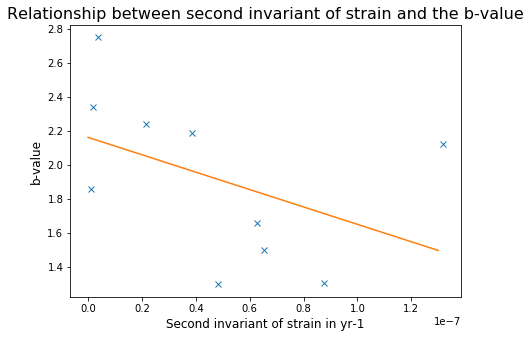

In [177]:
## Correlation strain and b -value
# CALCULATE SECOND INVARIANT
absolute_strain = []
for i in range(len(strain_b)):
    #e = np.sqrt(float(strain_b[i][0])**2+float(strain_b[i][1])**2+float(strain_b[i][2])**2)
    e = np.sqrt(float(strain_b[i][0])**2+float(strain_b[i][2])**2)
    absolute_strain.append(e)

final_b = []
final_strain = []

for i in range(len(bs)):
    if np.isnan(bs[i]) != True:
        final_b.append(bs[i])
        final_strain.append(absolute_strain[i])
    
poly_coeffs = np.polyfit(final_strain, final_b, 1)
x_line = np.linspace(0.4*10**-18, 1.3*10**-7, 100)
p1 = np.poly1d(poly_coeffs) 
    
fig = plt.figure(figsize=(7,5))

plt.plot((final_strain), final_b, 'x')
plt.plot(x_line, p1(x_line))

plt.xlabel('Second invariant of strain in yr-1', fontsize = 12)
plt.title('Relationship between second invariant of strain and the b-value', fontsize = 16)
plt.ylabel('b-value', fontsize = 12)

## Velocity

In [178]:
# for velocity, use sum of all the moment tensors. 
# but use with and length of fault too
# velocity = 1/(mu*L*W*t)* sum(m_0)
        
# Length of faults in boxes from a csv file
velocities = []
t = (2021-1976 + 10/12) *365.25*24*3600
mu =  3.3*10**10 
for i in range(len(scalar_moments)):
    m0 = float(scalar_moments[i])
    L = float(values[i][20]) #in m
    w = max_box_depth[i] 
    
    # change in seismogenic depth
    """
    if i == 14:
        w = 10000
    if i == 17:
        print(w)
        w = 1000
        """
    dip_fault = float(values[i][19])
    dip_rad = np.deg2rad(dip_fault)
    # sin(dip) = depth/W
    W = w/np.sin(float(dip_rad))
    v = m0/(L*mu*W*t)
    #convert to mm/yr
    vyr = v * 3.1556926 * 10 ** 10
    velocities.append([(values[i][0]), values[i][1], vyr])

18000.0
[-61.0604751774371, 9.80268477590019, 3.048780205646092]


In [179]:
# calculate corrected velocity
complete_scalar = []
box_count = 1
for i in scalar_moments:
    if box_count == 39:
        i = i + 5.7*10**21
    elif box_count == 41:
        i = i + 5.164 * 10** 20
    box_count += 1
    complete_scalar.append(i)

In [180]:
# Length of faults in boxes from a csv file
velocities_corr = []
t = (182) *365.25*24*3600
mu =  3.3*10**10 
for i in range(len(complete_scalar)):
    m0 = float(complete_scalar[i])
    L = float(values[i][20]) #in m
    w = float(values[i][28])
    dip_fault = float(values[i][19])
    dip_rad = np.deg2rad(dip_fault)
    # sin(dip) = depth/W
    W = w/np.sin(float(dip_rad))
    v = m0/(L*mu*W*t)
    #convert to mm/yr
    vyr = v * 3.1556926 * 10 ** 10
    velocities_corr.append([(values[i][0]), values[i][1], vyr])
print(velocities_corr[38])
print(velocities_corr[40])

[-65.627103363092, 18.0483926895456, 57.7595180141107]
[-63.188524268745, 17.0568951465715, 2.2983645393556533]


In [181]:
# in GMT, format is lon, lat, Evel (mm/yr), Nvel (mm/yr)
plot_psvelo = []
for i in range(len(velocities)):
    lon = velocities[i][0]
    lat = velocities[i][1]
    strike_fault = np.deg2rad(float(values[i][22]))
    velocity = velocities[i][2]
    Evel = velocity * np.sin(strike_fault)
    Nvel = velocity * np.cos(strike_fault)
    plot_psvelo.append([lon,lat,Evel,Nvel,0,0,0])

plt_psvelo = np.array(plot_psvelo)
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

np.savetxt('gmt_psvelo.txt', plt_psvelo, delimiter = ' ', fmt="%s")

In [182]:
# only top boxes compare to gps

# seismic coupling but only for the top boxes?
# coupling = velocity/gps velocity
coupling = []
coup =[]
for i in range(len(velocities)):
    gps_velocity = float(values[i][3])
    if np.isnan(gps_velocity) != True:
        velocity = float(velocities[i][2])
        lon = (values[i][0])
        lat = float(values[i][1])
        seismic_coupling = abs(velocity) / gps_velocity
        coupling.append([lon, lat, seismic_coupling])
        coup.append(seismic_coupling)

Text(0.5, 1, 'Heatmap of the seismic coupling at the caribbean plate')

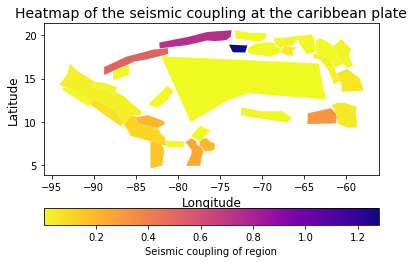

In [183]:
vandgps = gpd.GeoDataFrame.copy(polygons)

vandgps ['seismic_c'] = coup

fig, ax = plt.subplots(1, 1)
vandgps.plot(column='seismic_c', cmap='plasma_r', ax=ax, legend= True, legend_kwds={'label': "Seismic coupling of region",
                        'orientation': "horizontal"})
plt.xlabel('Longitude', fontsize = 12)
plt.ylabel('Latitude', fontsize = 12)
plt.title('Heatmap of the seismic coupling at the caribbean plate', fontsize = 14)

In [186]:
b_heatmap =[]
for i in range(len(velocities)):
    gps_velocity = float(values[i][3]) # check if shallow or deep zone
    if np.isnan(gps_velocity) != True:
        b_value = bs[i]
       # b_value = b_plot[i]
        b_heatmap.append(b_value)

Text(0.5, 1, 'Heatmap of the b-value at the caribbean plate')

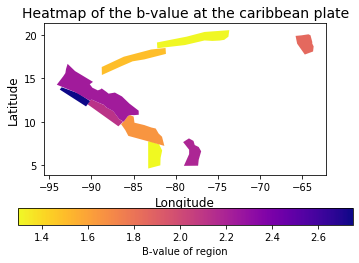

In [187]:
bandgps = gpd.GeoDataFrame.copy(polygons)

bandgps ['b_value'] = b_heatmap

fig, ax = plt.subplots(1, 1)
bandgps.plot(column='b_value', cmap='plasma_r', ax=ax, legend= True, legend_kwds={'label': "B-value of region",
                        'orientation': "horizontal"})
plt.xlabel('Longitude', fontsize = 12)
plt.ylabel('Latitude', fontsize = 12)
plt.title('Heatmap of the b-value at the caribbean plate', fontsize = 14)

Text(0.5, 1, 'Heatmap of the deformation type for regions in the caribbean plate')

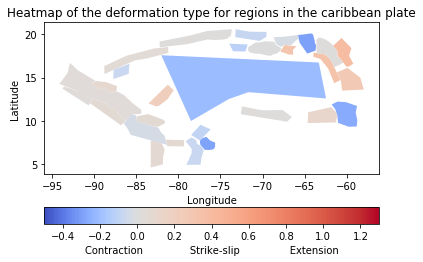

In [194]:
# style of deformation from my strain rates
# style of deformation from my strain rates
import matplotlib.colors as mcolors
class MidPointNormalize(mcolors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))
    
    
# calculate style tensor
def defstyle(emax, emin):
    return (emax+emin)/max(abs(emax), abs(emin))

strain_rates_boxes = []
strain_rates_boxes_depth = []
for i in range(len(strain_rates)):
    surface_box = float(values[i][3])
    if np.isnan(surface_box) != True:
        strain_rates_boxes.append(strain_rates[i])

defstyles = []       
for j in strain_rates_boxes:
    emax = j[2]
    emin = j[4]
    defs = defstyle(emax,emin)
    defstyles.append(defs)

    # -1 is contraction, +1 is extension, 0 is strike-slip
poly_deftype = gpd.GeoDataFrame.copy(polygons)
poly_deftype['def_type'] = defstyles

fig, ax = plt.subplots(1, 1)
norm=MidPointNormalize(-0.5, 1.3, 0)
poly_deftype.plot(column='def_type', cmap='coolwarm', norm = norm, ax=ax, legend= True, legend_kwds={'label': "Contraction               Strike-slip                Extension",
                        'orientation': "horizontal"})
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Heatmap of the deformation type for regions in the caribbean plate')

## velocities excluding Haïti earthquake

In [149]:
# data excluding earthquakes > 2010
with open('after2021mw0.txt') as f:
    array = [[x for x in line.split()] for line in f]
cmt_2010data = np.array(array)

In [150]:
# store tensors
tensors = []
coords = []
frequency = []
scalar_moments = []
box_depth = []
max_box_depth = []
mean_box_depth = []
areas = []

# depth constraints on boxes, mexico
box_depth1 = (-91.80953949802839, 12.906861060724344)
box_depth2 = (-89.35831739963655, 13.181528333815479)
box_depth3 = (-88.64458334948695, 13.991108344948625)
box_depth4 = (-83.30358287371013, 10.030047742119372)
box_depth5 = (-84.02616806517491, 8.858824465953603)
box_depth6 = (-88.33710672941535, 11.095631889667644)

# atlantic side
box_depth7 = (-60.0604751774371, 10.802684775900197)
box_depth8 = (-60.34008699007553, 17.9366145567412)
box_depth9 = (-66.94969911212416, 18.23183262090195)
box_depth10 = (-62.16092637903298, 16.327057534641476)
box_depth11 = (-69.7467461020565, 18.372244156357215)
box_depth12 = (-67.21882256716424, 19.305653288760155)
box_depth13 = (-64.62710336309205, 19.048392689545647)
box_depth14 = (-62.18852426874509, 18.056895146571513)
box_depth15 = (-60.34008699007553, 17.93661455674125)
box_depth16 = (-62.85911931879894, 10.523324857999352) # 60 km diep cutoff
box_depth17 = (-59.607810857910515, 14.652518442915289)

              
for i in coordinates:
    poly = Polygon(i)
    coord_poly = list(poly.centroid.coords)
    
    # keep track of number of earthquakes within polygon
    eq_zone = []
    eq_zone_depth = []
    freq_eqs1 = []
    freq_eqs2 = []
    scalar_moment1 = 0
    scalar_moment2 = 0
    number_eqs1 = 0
    eq_depths1 = 0
    max_depth1 = []
    number_eqs2 = 0
    eq_depths2 = 0
    max_depth2 = []
    depth_flag_atl = False
    depth_flag_mex = False
    for line in range(len(cmt_2010data)):
        x = (float(cmt_data[line][0]))
        y = (float(cmt_data[line][1]))
        point = Point(x,y)
        
        # add earthquakes to catalogue if it is within the polygon
        if (poly.contains(point)) == True:
            depth = (float(cmt_data[line][2]))
            # if we're in the right polygon, we will distinguish eqs between depths
            # depth constraints on boxes to do the summation twice. 
            
            # mexico side
            if coord_poly[0] == box_depth1 or coord_poly[0] == box_depth2 or coord_poly[0] == box_depth3 or coord_poly[0] == box_depth4 or coord_poly[0] == box_depth5 or coord_poly[0] == box_depth6:
                if depth < 60:
                    eq_zone.append(cmt_data[line])
                    eq_depths1 += depth
                    max_depth1.append(depth)
                    number_eqs1 += 1
                    scalar_moment1 += float(cmt_data[line][14])
                    freq_eqs1.append(float(cmt_data[line][13]))
                    depth_flag_mex = True
                else: 
                    eq_zone_depth.append(cmt_data[line])
                    eq_depths2 += depth
                    max_depth2.append(depth)
                    number_eqs2 += 1 
                    scalar_moment2 += float(cmt_data[line][14])
                    freq_eqs2.append(float(cmt_data[line][13]))
            # Atlanctic side        
            elif coord_poly[0] == box_depth7 or coord_poly[0] == box_depth8 or coord_poly[0] == box_depth9 or coord_poly[0] == box_depth10 or coord_poly[0] == box_depth11 or coord_poly[0] == box_depth12 or coord_poly[0] == box_depth13 or coord_poly[0] == box_depth14 or coord_poly[0] == box_depth15 or coord_poly[0] == box_depth16 or coord_poly[0] == box_depth17:
                if depth < 40:
                    eq_zone.append(cmt_data[line])
                    eq_depths1 += depth
                    max_depth1.append(depth)
                    number_eqs1 += 1
                    scalar_moment1 += float(cmt_data[line][14])
                    freq_eqs1.append(float(cmt_data[line][13]))
                    depth_flag_atl = True
                else: 
                    eq_zone_depth.append(cmt_data[line])
                    eq_depths2 += depth
                    max_depth2.append(depth)
                    number_eqs2 += 1 
                    scalar_moment2 += float(cmt_data[line][14])
                    freq_eqs2.append(float(cmt_data[line][13]))
            # if the box is not divided by depth, all earthquakes are included         
            else: 
                eq_zone.append(cmt_data[line])
                eq_depths1 += depth
                max_depth1.append(depth)
                number_eqs1 += 1
                scalar_moment1 += float(cmt_data[line][14])
                freq_eqs1.append(float(cmt_data[line][13]))
            # collect data for frequency magnitude plot
            
            
    if number_eqs1 == 0:
        mean_depth1 = 0
    else: 
        mean_depth1 = eq_depths1 / number_eqs1
        # seismogenic depth is depth where 90% of earthquakes lie in.
        max_depth1.sort()
        length = len(max_depth1)
        index = round(length*0.9)
        # index -1 to accomodate for counting from 0 in Python
        max_depths1 = max_depth1[index-1]
        max_box_depth.append(max_depths1 * 1000) #from kilometres to m
        mean_box_depth.append(mean_depth1)
        
    box_depth.append(max_depths1*1000) #from kilometres to m
    scalar_moments.append([*coord_poly, scalar_moment1/10**7])# convert to Nm from dyn
    frequency.append([*coord_depth,*freq_eqs1])
    mrr,mtt,mpp,mrt,mrp,mtp = kostrov_summation(eq_zone)

    tensors.append([*coord_poly[0],mean_depth1,mrr,mtt,mpp,
                    mrt,mrp,mtp,16,'X', 'Y', '200808180916A'])
    
    # Calculate the areas of the polygon  
    s = shape(poly)
    # from spherical to cartesian coordinates
    proj = partial(pyproj.transform, pyproj.Proj(init='epsg:4326'),
               pyproj.Proj(init='epsg:3857'))
    s_new = transform(proj, s)
    poly_area = transform(proj, s).area
    areas.append(poly_area)
    
    # if eq_zone_depth is not empty, we will do kostrov summation on a bottom of box as well
    if len(eq_zone_depth) != 0:
        mean_depth2 = eq_depths2 / number_eqs2
        mean_box_depth.append(mean_depth2)
        if depth_flag_atl == True:
            # 40 km is the upper depth of the box
            # seismogenic depth is depth where 90% of earthquakes lie in.
            max_depth2.sort()
            length2 = len(max_depth2)
            index2 = round(length2*0.9)
            # index -1 to accomodate for counting from 0 in Python
            # -40 to get the right height of the box
            max_depths2 = float(max_depth2[index2 - 1]) - 40
            max_box_depth.append(max_depths2 * 1000) #from kilometres to m
        elif depth_flag_mex == True:
            # 60 km is the upper depth of the box
            # seismogenic depth is depth where 90% of earthquakes lie in.
            max_depth2.sort()
            length2 = len(max_depth2)
            index2 = round(length2*0.9)
            # index -1 to accomodate for counting from 0 in Python
            # -60 to get the right height of the box
            max_depths2 = float(max_depth2[index2 - 1]) - 60
            max_box_depth.append(max_depths2 * 1000) #from kilometres to m
        
        # two boxes for depths so area twice in the list
        areas.append(poly_area)
        box_depth.append(mean_depth2*1000) #from kilometres t
        scalar_moments.append([*coord_depth,scalar_moment2/10**7])# convert to Nm from dyn
        dmrr, dmtt, dmpp, dmrt, dmrp, dmtp = kostrov_summation(eq_zone_depth)    
        frequency.append([*coord_depth,*freq_eqs2])
        # want new coordinates for deep boxes in order to recognise them on the GMT map
        coord_depth = np.subtract(coord_poly[0], (0.5, 1))
        tensors.append([*coord_depth,mean_depth2,dmrr,dmtt,dmpp,
                    dmrt,dmrp,dmtp,16,'X', 'Y', '200808180916D'])

In [151]:
# calculate velocity for enriquillo-plantain box before 2021
for i in scalar_moments:
    if i[0]== -72.82107350541658 and i[1]== 18.482213329241386:
        print(i[2])

4.263999999999999e+19 for earthquakes before 
loading earthquakes before 2010 generates 0 M0 so no seismicity before 2010

In [157]:
# calculate corresponding velocity
velocities_corr = []
t = (182) *365.25*24*3600
mu =  3.3*10**10 
m0 = float(4.263999999999999e+19)
L = float(values[8][20]) #in m
w = float(values[8][28])
dip_fault = float(values[8][19])
dip_rad = np.deg2rad(dip_fault)
# sin(dip) = depth/W
W = w/np.sin(float(dip_rad))
v = m0/(L*mu*W*t)
#convert to mm/yr
vyr = v * 3.1556926 * 10 ** 10
print('Velocity in EP fault system before the 2021 M7.2 earhquake; ', vyr)

Velocity in EP fault system before the 2021 M7.2 earhquake;  1.3338909698384187
